In [34]:
# Update numpy and other libraries to compatible versions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.arima.model import ARIMA

In [29]:
import warnings
warnings.filterwarnings('ignore')

In [30]:
###we first setup the dataset for the purpose of solving part a
#loading data
data = pd.read_csv("pl.csv")
data['timestamp'] = pd.to_datetime(data['timestamp']) - pd.Timedelta(seconds=1)## to deal with the 12 o clock problem
data['date'] = data['timestamp'].dt.date

data_grouped = data.groupby(['vehicle_no', 'date'])
spent = []
for (vehicle_no, date), vehicle_data in data_grouped:

    if len(vehicle_data) % 2 == 0:
        i = 0
        while i < len(vehicle_data) - 1:
            diff = vehicle_data["timestamp"].iloc[i + 1] - vehicle_data['timestamp'].iloc[i]
            spent.append({'date': date, 'time': (diff.total_seconds())/60})
            i += 2
df = pd.DataFrame(spent)
df = df.groupby('date').mean()
df_train=df.iloc[0:-7]
df_test=df.iloc[-7:]

In [31]:
p_value = sm.tsa.stattools.adfuller(df_train)[1]
print(p_value)
####Since the ADF test gives such a small value we can conclude that the dataset is stationary

0.6731196248236375


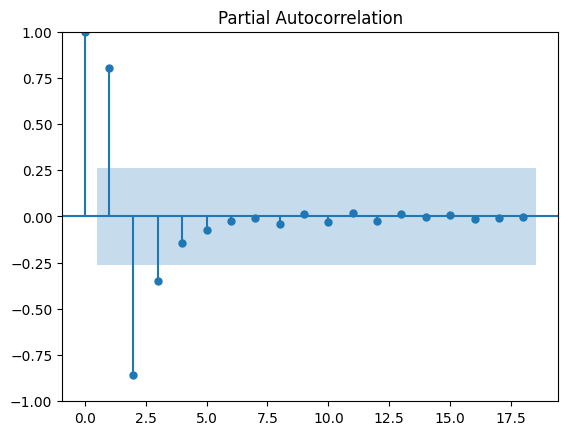

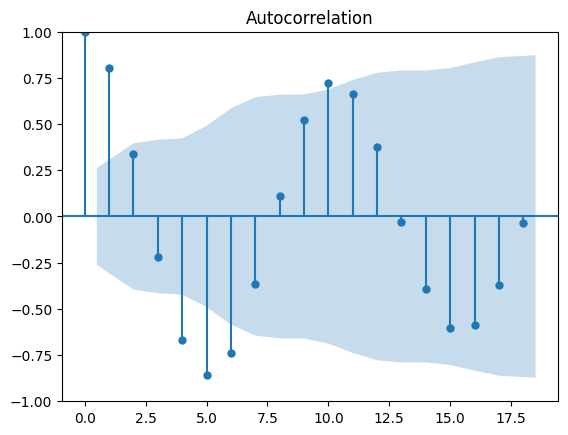

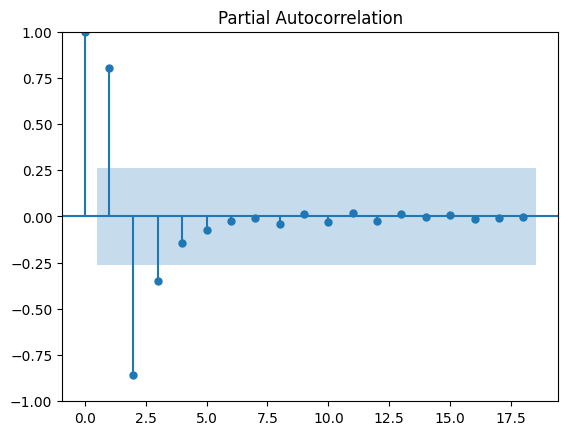

In [32]:
smt.graphics.plot_acf(df_train)
smt.graphics.plot_pacf(df_train)

In [47]:
model=ARIMA(df_train,order=(3,1,0)) ###lags=3 was decided by the PACF plot above
model_fit=model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   time   No. Observations:                   56
Model:                 ARIMA(3, 1, 0)   Log Likelihood                -170.014
Date:                Sun, 19 Jan 2025   AIC                            348.028
Time:                        19:11:26   BIC                            356.057
Sample:                    09-12-2024   HQIC                           351.133
                         - 11-06-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9588      0.097      9.918      0.000       0.769       1.148
ar.L2          0.1205      0.158      0.762      0.446      -0.190       0.431
ar.L3         -0.6794      0.097     -7.034      0.0

<Axes: xlabel='date'>

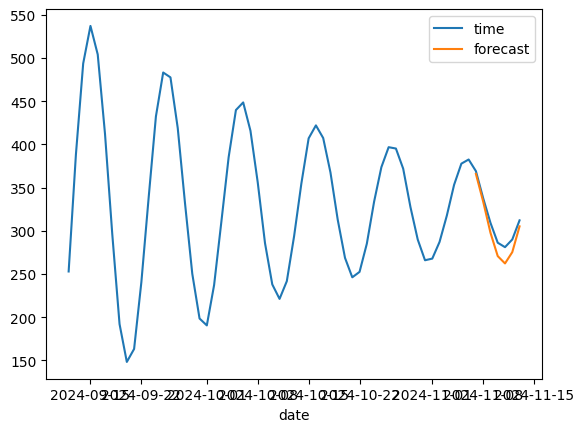

In [50]:
forecast=model_fit.forecast(len(df_test['time']))
df['forecast']=[None]*len(df_train['time']) + list(forecast)
df.plot()

In [51]:
mae = mean_absolute_error(df_test, forecast)
mape = mean_absolute_percentage_error(df_test, forecast)
print("mae:",mae)
print("mape:",mape)

mae: 10.660359854381786
mape: 0.03595283714595789


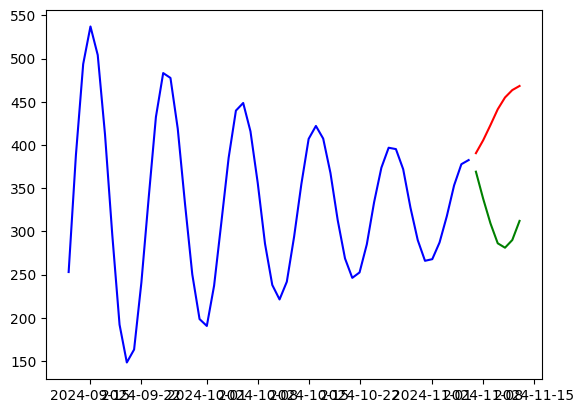

mae: 123.1769660145586
mape: 0.4126200428808403


In [41]:
model=ETSModel(df_train["time"],error="add",trend="add",seasonal="add",seasonal_periods=7)
model=model.fit()
forecast=model.forecast(steps=len(df_test))
plt.plot(df_train.index,df_train,color='b',label='train')
plt.plot(forecast.index,forecast,color='r',label='forecast')
plt.plot(df_test.index,df_test,color='g',label='test')
plt.show()
mae = mean_absolute_error(df_test, forecast)
mape = mean_absolute_percentage_error(df_test, forecast)
print("mae:",mae)
print("mape:",mape)
###clearly the ets model is very bad for this dataset